# Machine learning CS-C3240 project code

### Imports

In [1]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error # for regression


### Dataset

In [2]:
# reading the dataset
df = pd.read_csv('bergen_merged.csv')

print("Dataset Shape:", df.shape)
print(df.head())

Dataset Shape: (467861, 19)
            start_time             end_time  duration  start_station_id  \
0  2023-01-01 04:00:00  2023-01-01 04:00:00       629               150   
1  2023-01-01 04:00:00  2023-01-01 04:00:00       107              1894   
2  2023-01-01 04:00:00  2023-01-01 04:00:00       643              1894   
3  2023-01-01 05:00:00  2023-01-01 05:00:00       227               797   
4  2023-01-01 05:00:00  2023-01-01 06:00:00       254                22   

  start_station_name  start_station_latitude  start_station_longitude  \
0             Torget               60.395878                 5.325284   
1   Kong Oscars gate               60.393323                 5.330654   
2   Kong Oscars gate               60.393323                 5.330654   
3   John Lunds plass               60.388247                 5.324558   
4            Skur 11               60.396384                 5.324169   

   end_station_id     end_station_name  end_station_latitude  \
0            1896 

In [3]:
print(df.info)

<bound method DataFrame.info of                  start_time             end_time  duration  start_station_id  \
0       2023-01-01 04:00:00  2023-01-01 04:00:00       629               150   
1       2023-01-01 04:00:00  2023-01-01 04:00:00       107              1894   
2       2023-01-01 04:00:00  2023-01-01 04:00:00       643              1894   
3       2023-01-01 05:00:00  2023-01-01 05:00:00       227               797   
4       2023-01-01 05:00:00  2023-01-01 06:00:00       254                22   
...                     ...                  ...       ...               ...   
467856  2023-12-31 21:00:00  2023-12-31 21:00:00       491                49   
467857  2023-12-31 21:00:00  2023-12-31 21:00:00       269               156   
467858  2023-12-31 21:00:00  2023-12-31 22:00:00       566              2322   
467859  2023-12-31 22:00:00  2023-12-31 22:00:00       697               818   
467860  2023-12-31 22:00:00  2023-12-31 22:00:00       758               219   

       

### Preprocessing

In [4]:
# this code block does preprocessing

# Convert datetime format
df['start_time'] = pd.to_datetime(df['start_time'])

# Extract date and hour
df['date'] = df['start_time'].dt.date
df['hour'] = df['start_time'].dt.hour

# Group and aggregate
aggregated_df = df.groupby(['date', 'hour']).agg(
    count=('duration', 'size'),
    precipitation=('precipitation', 'first'),
    temperature=('temperature', 'first'),
    wind_speed=('wind_speed', 'first'),
    weather=('weather', 'first'),
    sunshine=('sunshine', 'first'),
    season=('season', 'first'),
    is_holiday=('is_holiday', 'first'),
    is_weekend=('is_weekend', 'first')
).reset_index()


# convert is_holiday and is_weekend to 0 and 1
aggregated_df['is_holiday'] = aggregated_df['is_holiday'].astype(int)
aggregated_df['is_weekend'] = aggregated_df['is_weekend'].astype(int)

# Create is_workingday column: 1 if neither a weekend nor a holiday, otherwise 0
aggregated_df['is_workingday'] = ((aggregated_df['is_weekend'] == 0) & (aggregated_df['is_holiday'] == 0)).astype(int)


# convert date to datetime format
aggregated_df['date'] = pd.to_datetime(aggregated_df['date'])


# month and day of the week
aggregated_df['month'] = aggregated_df['date'].dt.month
aggregated_df['day_of_week'] = aggregated_df['date'].dt.dayofweek

aggregated_df = aggregated_df.drop(columns=['date'])


print(aggregated_df.head())

   hour  count  precipitation  temperature  wind_speed  weather  sunshine  \
0     4      3            0.0         -1.8         1.7        1         0   
1     5      2            0.0         -1.9         4.3        1         0   
2     6      7            0.0          0.6         5.1        1         0   
3     7      4            0.0         -0.8         4.3        1         0   
4     9      1            0.0         -2.9         2.1        1         0   

   season  is_holiday  is_weekend  is_workingday  month  day_of_week  
0       3           1           1              0      1            6  
1       3           1           1              0      1            6  
2       3           1           1              0      1            6  
3       3           1           1              0      1            6  
4       3           1           1              0      1            6  


In [5]:
# more preprocessing
# categories for the weather ids done by ChatGPT

clear_sunny = [1, 2, 3]
cloudy_overcast = [4, 15]
rain_showers = [5, 6, 9, 10, 11, 24, 25, 30, 40, 41, 46]
snow_sleet_thunder = [7, 8, 12, 13, 14, 20, 21, 22, 23, 26, 27, 28, 29, 31, 32, 33, 34, 42, 43, 44, 45, 47, 48, 49, 50]

# Create a dictionary that maps the weather values to the categories
weather_mapping = {w: 0 for w in clear_sunny}
weather_mapping.update({w: 1 for w in cloudy_overcast})
weather_mapping.update({w: 2 for w in rain_showers})
weather_mapping.update({w: 3 for w in snow_sleet_thunder})

# Apply the mapping to the weather column
aggregated_df['weather'] = aggregated_df['weather'].replace(weather_mapping)

weather_dummies = pd.get_dummies(aggregated_df['weather'], prefix='weather').astype(int)
season_dummies = pd.get_dummies(aggregated_df['season'], prefix='season').astype(int)
aggregated_df = pd.concat([aggregated_df, weather_dummies, season_dummies], axis=1)
aggregated_df = aggregated_df.drop(columns=['weather', 'season'])


print(aggregated_df.head())

   hour  count  precipitation  temperature  wind_speed  sunshine  is_holiday  \
0     4      3            0.0         -1.8         1.7         0           1   
1     5      2            0.0         -1.9         4.3         0           1   
2     6      7            0.0          0.6         5.1         0           1   
3     7      4            0.0         -0.8         4.3         0           1   
4     9      1            0.0         -2.9         2.1         0           1   

   is_weekend  is_workingday  month  day_of_week  weather_0  weather_1  \
0           1              0      1            6          1          0   
1           1              0      1            6          1          0   
2           1              0      1            6          1          0   
3           1              0      1            6          1          0   
4           1              0      1            6          1          0   

   weather_2  weather_3  season_0  season_1  season_2  season_3  
0       

In [6]:
aggregated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6956 entries, 0 to 6955
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   hour           6956 non-null   int32  
 1   count          6956 non-null   int64  
 2   precipitation  6956 non-null   float64
 3   temperature    6956 non-null   float64
 4   wind_speed     6956 non-null   float64
 5   sunshine       6956 non-null   int64  
 6   is_holiday     6956 non-null   int64  
 7   is_weekend     6956 non-null   int64  
 8   is_workingday  6956 non-null   int64  
 9   month          6956 non-null   int32  
 10  day_of_week    6956 non-null   int32  
 11  weather_0      6956 non-null   int64  
 12  weather_1      6956 non-null   int64  
 13  weather_2      6956 non-null   int64  
 14  weather_3      6956 non-null   int64  
 15  season_0       6956 non-null   int64  
 16  season_1       6956 non-null   int64  
 17  season_2       6956 non-null   int64  
 18  season_3

### Visualising the dataset

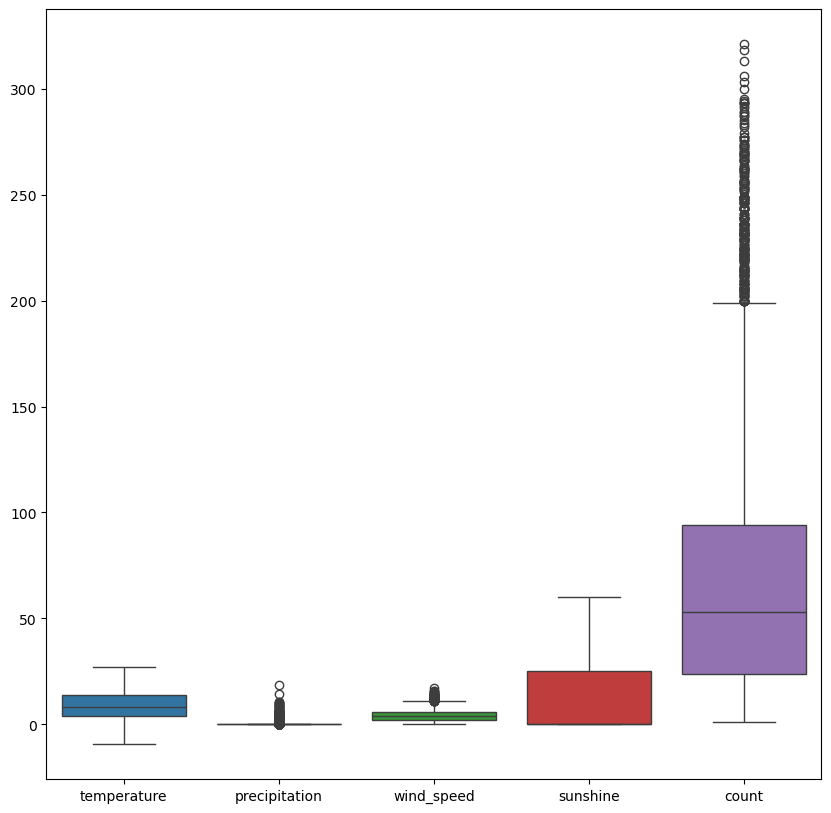

In [7]:
# visualising
sns.boxplot(data=aggregated_df[['temperature',
       'precipitation', 'wind_speed', 'sunshine', 'count']])
fig=plt.gcf()
fig.set_size_inches(10,10)

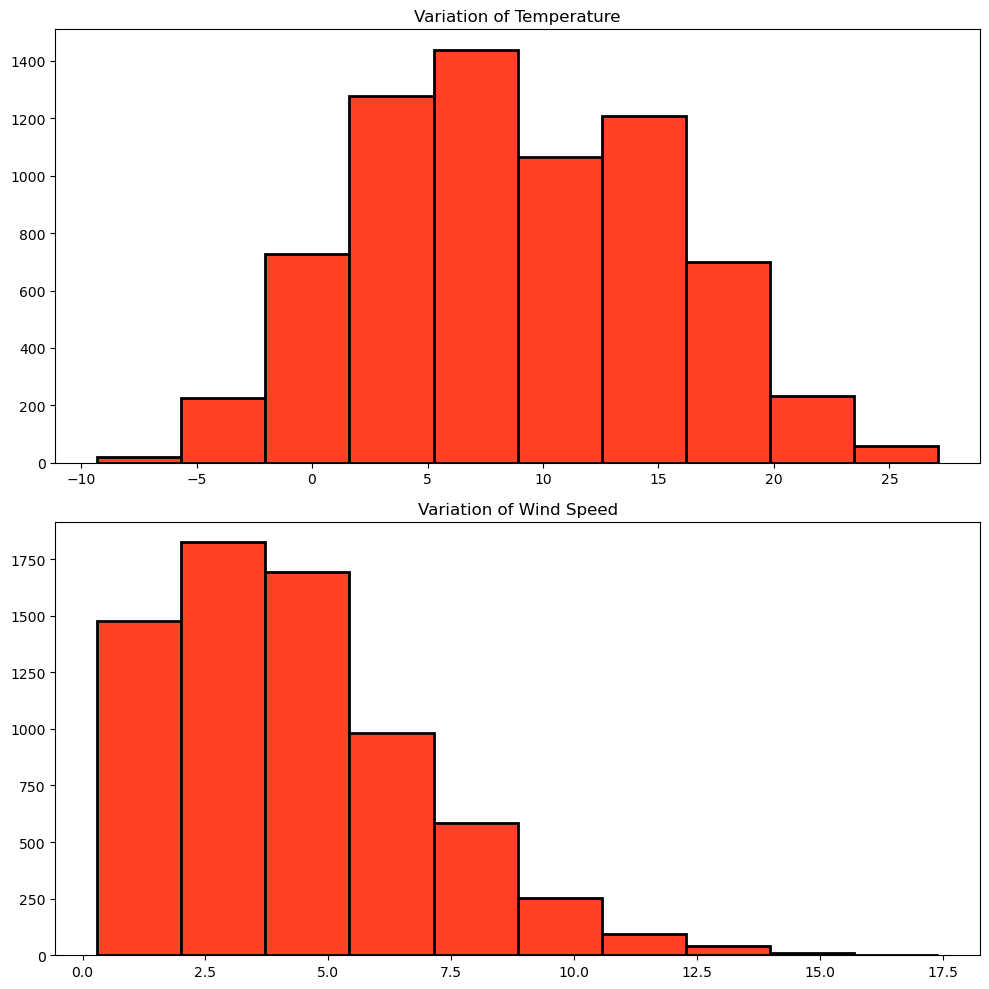

In [8]:
# visualising
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

axes[0].hist(aggregated_df["temperature"], edgecolor="black", linewidth=2, color='#ff4125')
axes[0].set_title("Variation of Temperature")

axes[1].hist(aggregated_df["wind_speed"], edgecolor="black", linewidth=2, color='#ff4125')
axes[1].set_title("Variation of Wind Speed")

plt.tight_layout()
plt.show()

<Axes: >

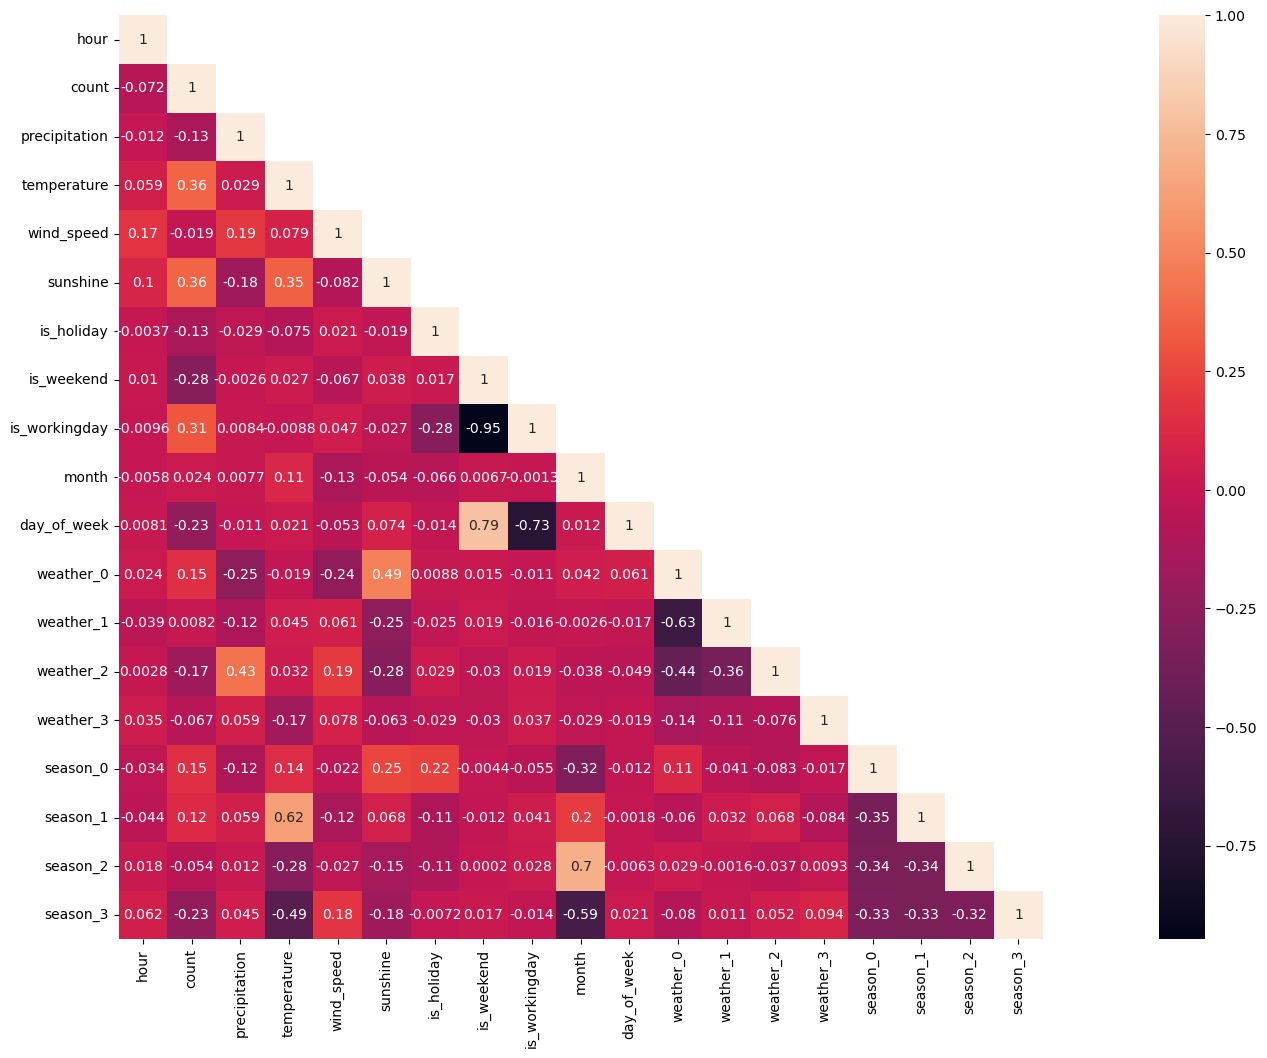

In [9]:
#corelation matrix.
cor_mat= aggregated_df[:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

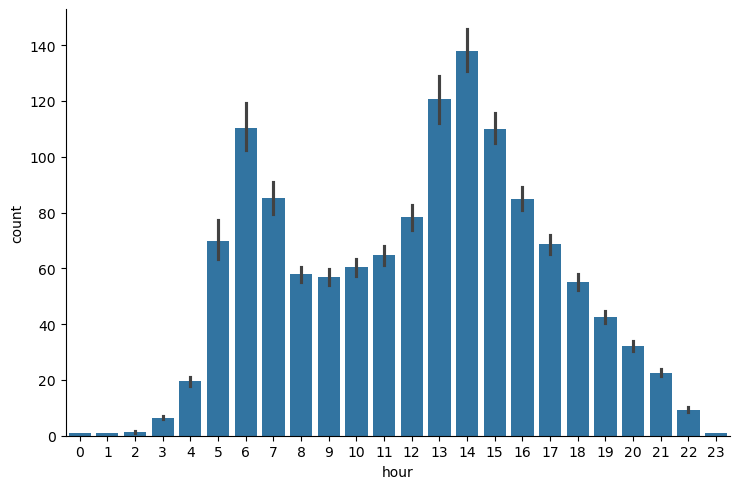

In [10]:
# visualising how bike trips are distributed by hour
sns.catplot(x="hour", y="count", data=aggregated_df, kind="bar", height=5, aspect=1.5)

plt.show()

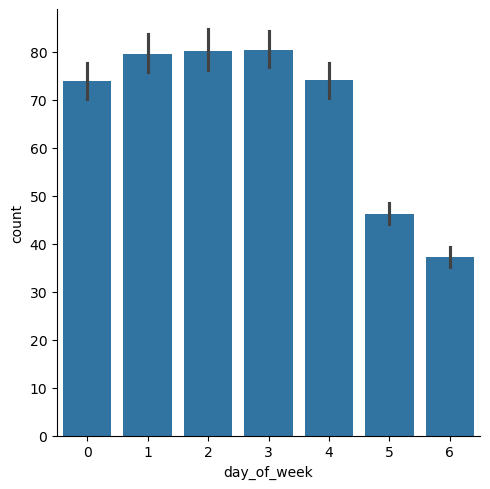

In [11]:
# visualising how bike trips are distributed by day
sns.catplot(x="day_of_week", y="count", kind="bar", data=aggregated_df, height=5, aspect=1)

plt.show()

## Machine learning

#### Splitting the dataset

In [12]:
from sklearn.model_selection import train_test_split

# Defining the features and target
X = aggregated_df.drop(columns=['count'])
y = aggregated_df['count']

# Splitting the data into training (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

# Check the sizes of the splits
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 4869
Validation set size: 1043
Test set size: 1044


###  Random forest regression

In [13]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rf_val_scores = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    rf_regressor.fit(X_train_fold, y_train_fold)
    y_val_pred = rf_regressor.predict(X_val_fold)
    
    # MSE for the validation fold
    mse_val = mean_squared_error(y_val_fold, y_val_pred)
    rf_val_scores.append(mse_val)
    

# mean and std of MSE for validation
mean_mse_rf_val = np.mean(rf_val_scores)
std_mse_rf_val = np.std(rf_val_scores)


y_test_pred_rf = rf_regressor.predict(X_test)

# MSE test set
mse_rf_test = mean_squared_error(y_test, y_test_pred_rf)

print(f"Random Forest Validation MSE: {mean_mse_rf_val:.4f} ± {std_mse_rf_val:.4f}")
print(f"Random Forest Test MSE: {mse_rf_test:.4f}")

Random Forest Validation MSE: 475.2994 ± 22.0911
Random Forest Test MSE: 449.2515


### Multi-layer perceptron regressor

In [15]:
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

mlp_regressor = MLPRegressor(random_state=42, max_iter=10000)

#K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mlp_val_scores = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    mlp_regressor.fit(X_train_fold, y_train_fold)
    y_val_pred = mlp_regressor.predict(X_val_fold)

    y_val_pred = np.maximum(y_val_pred, 0)

    #MSE for the validation fold
    mse_val = mean_squared_error(y_val_fold, y_val_pred)
    mlp_val_scores.append(mse_val)

#mean and std of MSE for validation
mean_mse_mlp_val = np.mean(mlp_val_scores)
std_mse_mlp_val = np.std(mlp_val_scores)

# Predict
y_test_pred_mlp = mlp_regressor.predict(X_test)

y_test_pred_mlp = np.maximum(y_test_pred_mlp, 0)

# MSE test set
mse_mlp_test = mean_squared_error(y_test, y_test_pred_mlp)

print(f"MLP Validation MSE: {mean_mse_mlp_val:.4f} ± {std_mse_mlp_val:.4f}")
print(f"MLP Test MSE: {mse_mlp_test:.4f}")


MLP Validation MSE: 1153.0362 ± 204.4380
MLP Test MSE: 1183.1632
